<a href="https://colab.research.google.com/github/chaewoncutie/final-code-pls-run/blob/main/Kmeans_K%3D14_with_cluster_profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy wordcloud ipywidgets umap-learn hdbscan

In [2]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, davies_bouldin_score, calinski_harabasz_score, precision_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import numpy as np
import umap
from google.colab import files
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
file_name = next(iter(uploaded))
df = pd.read_json(file_name, lines=True)

# Data Cleaning and Preprocessing
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")
display(df.head())

df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)
print(f"Null values in each column:\n{df.isnull().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

df = df.dropna(subset=['headline', 'short_description'])
df = df.drop_duplicates()
df = df[df['date'].dt.year.isin(range(2017, 2023))]
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3 (2).json
Number of rows in original dataset: 209527
Number of columns in original dataset: 6


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


<ipython-input-4-a4f9f06a9c59>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [5]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\btrump\b', '', text)  # Remove "trump"
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [6]:
# Tokenization, Stopword Removal, and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [7]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=4000, stop_words='english', max_df=0.5, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df['filtered_text'])

In [8]:
# Dimensionality Reduction
svd = TruncatedSVD(n_components=min(X.shape[1], 2500), random_state=42)
X_svd = svd.fit_transform(X).astype(np.float32)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by selected components: {explained_variance:.4f}")

Total explained variance by selected components: 0.8761


In [9]:
# UMAP for further dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_umap)

In [11]:
selected_k = [14]
kmeans_models = {}
kmeans_labels = {}
kmeans_metrics = {}

for k in selected_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_normalized)
    df[f'cluster_kmeans_{k}'] = labels
    kmeans_models[k] = kmeans
    kmeans_labels[k] = labels
    kmeans_metrics[k] = {
        'silhouette': silhouette_score(X_normalized, labels),
        'davies_bouldin': davies_bouldin_score(X_normalized, labels),
        'calinski_harabasz': calinski_harabasz_score(X_normalized, labels),
        'precision': precision_score(labels, labels, average='macro', zero_division=1),
        'adjusted_rand': adjusted_rand_score(labels, labels),
        'nmi': normalized_mutual_info_score(labels, labels),
        'similarity': cosine_similarity(X_normalized).mean()
    }

# Display Metrics
for k, metrics in kmeans_metrics.items():
    print(f"Metrics for k = {k}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    print("-")

Metrics for k = 14:
silhouette: 0.3387
davies_bouldin: 0.6915
calinski_harabasz: 28055.8092
precision: 1.0000
adjusted_rand: 1.0000
nmi: 1.0000
similarity: 0.0000
-


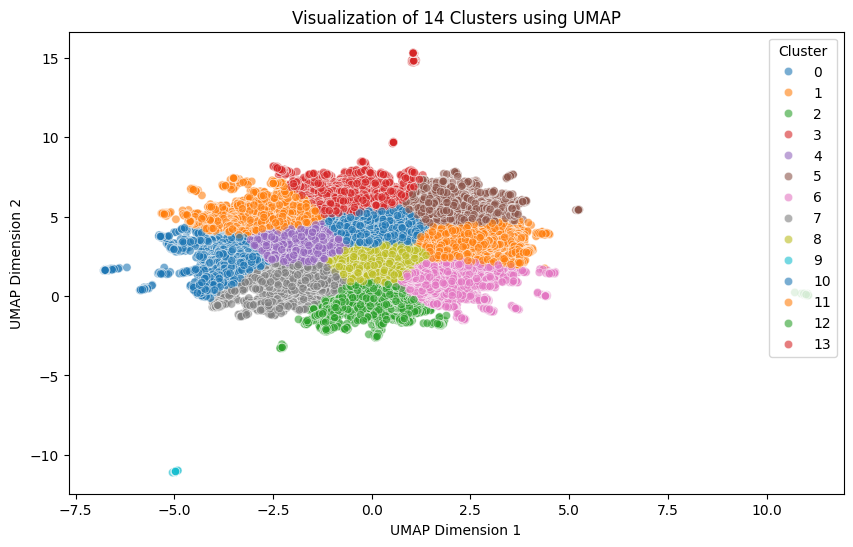

In [12]:
for k in selected_k:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=kmeans_labels[k], palette='tab10', alpha=0.6)
    plt.title(f'Visualization of {k} Clusters using UMAP')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(title='Cluster')
    plt.show()

In [14]:
# Cluster Profiling
for k in selected_k:
    print(f"Cluster Profiles for k = {k}")
    for cluster_num in range(k):
        cluster_data = df[df[f'cluster_kmeans_{k}'] == cluster_num]
        most_common_words = pd.Series(' '.join(cluster_data['filtered_text']).split()).value_counts().head(10)
        print(f"Cluster {cluster_num}:")
        print(most_common_words)
        print("---")

Cluster Profiles for k = 14
Cluster 0:
north        481
korea        450
new          325
white        294
u            276
president    243
say          229
trump        204
people       189
said         178
Name: count, dtype: int64
---
Cluster 1:
said         688
president    471
new          467
say          447
u            373
people       331
state        315
year         314
biden        305
trump        277
Name: count, dtype: int64
---
Cluster 2:
trump        574
donald       454
president    358
ban          346
house        251
say          247
u            241
new          241
said         240
white        237
Name: count, dtype: int64
---
Cluster 3:
say          412
said         355
new          283
u            273
trump        259
president    256
gun          252
sexual       218
woman        214
donald       209
Name: count, dtype: int64
---
Cluster 4:
new          446
say          373
people       337
u            331
president    300
time         269
year         26